## Extension of the 10% pool in paper 1

In [2]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import scipy.stats 

import matplotlib.gridspec as gspec

import os
import sys
import warnings
warnings.filterwarnings("ignore")

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
sns.set_context('notebook')
sns.set_style('white')

In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/ptracersGlob.nc'

In [5]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [6]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

for ii in range(len(records)):
    print(ii,records[ii].name, records[ii].epsilon,records[ii].kv)
select_rec = [0,2,38,11,49,33,31,5,10,18]
    
records2 = [records[0],
            records[38],
            records[11],
            records[49],
            records[33],
            records[31],
            records[5],
            records[10],
            records[18],
            ]


recordsNoC2 = [recordsNoC[0],
               recordsNoC[38],
               recordsNoC[11],
               recordsNoC[49],
               recordsNoC[33],
               recordsNoC[31],
               recordsNoC[5],
               recordsNoC[10],
               recordsNoC[18],
               ]



0 CNTDIFF_run38 5 1e-05
1 CNTDIFF_run37 5 0.0001
2 CNTDIFF_run36 5 0.001
3 CNTDIFF_run45 5 1e-05
4 CNTDIFF_run73 5 1e-05
5 CNTDIFF_run75 5 1e-05
6 CNTDIFF_run79 5 1e-05
7 CNTDIFF_run67 5 1e-05
8 CNTDIFF_run51 5 1e-05
9 CNTDIFF_run69 5 1e-05
10 CNTDIFF_run71 5 1e-05
11 3DVISC_run01 5 0.001
12 3DVISC_run02 5 0.0001
13 3DVISC_run04 5 0.0001
14 3DVISC_run03 5 0.001
15 3DVISC_run05 5 0.005
16 3DVISC_run06 5 0.01
17 LOWER_BF_run01 5 1e-05
18 LOW_BF_run01 5 1e-05
19 LOWEST_BF_run01 5 1e-05
20 LOWEST_BF_run03 5 1e-05
21 LOWEST_BF_run05 5 1e-05
22 LOWEST_BF_run07 5 1e-05
23 LOWEST_BF_run11 5 0.001
24 3DVISC_REALISTIC_run01 50 0.0091
25 3DVISC_REALISTIC_run02 50 0.00122
26 3DVISC_REALISTIC_run03 50 0.00811
27 3DVISC_REALISTIC_run05 50 0.0015
28 3DVISC_REALISTIC_run06 50 0.00154
29 3DVISC_REALISTIC_run07 10 0.01
30 3DVISC_REALISTIC_run08 25 0.01
31 3DVISC_REALISTIC_run09 50 0.01
32 3DVISC_REALISTIC_run10 100 0.01
33 3DVISC_REALISTIC_run11 15 0.01
34 3DVISC_REALISTIC_run12 75 0.01
35 3DVISC_REALIS

In [7]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,cont_value,col, lines='solid'):
    
    #ax.axvline(X[xind_CS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    ax.axhline(Y[yind_AS]/1000, color = '0.5', linestyle = ':', linewidth = 1)
    
    BAC = ConcFilt[yslice,xslice]
    
   
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[cont_value], 
                      colors=col, linestyles=lines,
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
def PlotAS(ax,Conc,xsl,zsl,cont_value,col, lines='solid'):
    print(np.shape(X[xsl]/1000),np.shape(Z[zsl]), np.shape(Conc))
   
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[cont_value], 
                      colors=col,linestyles=lines, 
                      )
    
    ax.plot(X[xsl]/1000,-Depth[yind_AS,xsl],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,cont_value,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[cont_value], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [8]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 286
xind_CS = 260

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

In [8]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT, Area = BottomConc(np.mean(nbl.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        rec.concAS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC run01
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


In [9]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT_ini, Area = BottomConc(nbl.variables['Tr1'][0,:,:,:],hFacC,rA,Depth)
        rec.concAS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )


done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC run01
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


In [10]:
for rec, recNoC in zip(records2, recordsNoC2):
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, rec.concBOT_anom, Area = BottomConc(np.nanmean(nbl.variables['Tr1'][8:18,:,:,:]-
                                                          noc.variables['Tr1'][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            rec.concAS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                     noc.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                          mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            rec.concCS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                          mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer 3DVISC_REALISTIC run16
done with tracer 3DVISC run01
done with tracer 3DVISC_REALISTIC run27
done with tracer 3DVISC_REALISTIC run11
done with tracer 3DVISC_REALISTIC run09
done with tracer CNTDIFF run75
done with tracer CNTDIFF run71
done with tracer LOW_BF run01


## Bottom concentrations

In [11]:
for rec, recNoC in zip(records2, recordsNoC2):
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    rec.BCA = np.empty((nt,ny,nx))
    rec.BC = np.empty((nt,ny,nx))
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                rec.BCA[ii,:,:], dummy, rec.AreaTot1 = BottomConc(noc.variables['Tr1'][ii,:,:,:], hFacCNoC,rA,Depth)
                rec.BC[ii,:,:], dummy, rec.AreaTot2 = BottomConc(nbl.variables['Tr1'][ii,:,:,:],hFacCNoC,rA,Depth)


(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


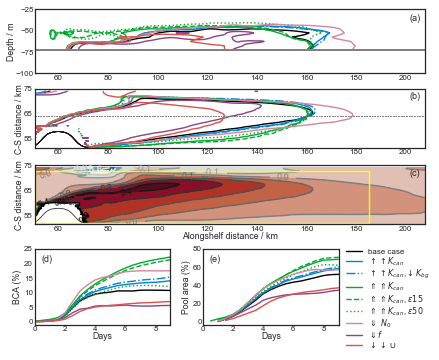

In [12]:
linestyles=['solid','solid','dashdot','solid','dashed','dotted','solid','solid','solid']


f1 = plt.figure(figsize = (7,5.8)) # 19.0cm = 7.4in, 115cm = 4.52in
sns.set_style('white')
sns.set_context('paper')
gs0 = gspec.GridSpec(2, 1, height_ratios=[1,0.35], hspace=0.15)
gs01 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
gs02 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1],width_ratios=[1,1,0.4], wspace=0.3)
    
ax2 = plt.subplot(gs01[1])
ax3 = plt.subplot(gs01[2])
ax0 = plt.subplot(gs01[0])
ax4 = plt.subplot(gs02[0])
ax5 = plt.subplot(gs02[1])

ii = 0    

CONT = 0.1

yslice2 = slice(225,320)
xslice2 = slice(120,500)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)
xslice_AS = slice(120,500)


for rec,line in zip(records2, linestyles):
    
    # -------- 10% contours ----------
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice2,yslice2,CONT,sns.xkcd_rgb[rec.color], lines=line)
    
    # -------- Thickness, 10% contours -----
    PlotAS(ax0,(rec.concAS_anom[zslice_AS2, :]/rec.concAS_ini[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,
           sns.xkcd_rgb[rec.color], lines=line)
    
    # ------- BCA ----------
    ax4.plot(np.arange(19)/2,(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                                (np.nansum(rec.AreaTot2[227:315,120:463])))/
                               (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                               ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                                 (np.nansum(rec.AreaTot1[227:315,120:463])))/
                                (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))*100,
             color=sns.xkcd_rgb[rec.color], label=rec.label2, linestyle=line)
    # ----- AREA ------------
    area_array = np.zeros(19)
    for tt in range(19):
        can = (rec.BC[tt,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))/(rec.BC[0,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))
        noc = (rec.BCA[tt,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))/(rec.BCA[0,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))
        anomaly = np.ma.masked_less((can-noc)*100,10)
        mask = np.ma.getmask(anomaly)
        area_array[tt] = np.sum(np.ma.masked_array(rec.AreaTot2[227:315,120:463], mask = mask))
        
    ax5.plot(np.arange(19)/2, (area_array/np.nansum(rec.AreaTot2[227:315,120:463]))*100, color=sns.xkcd_rgb[rec.color],
             label=rec.label2, linestyle=line)

# --------- CONTOURS -------------------------
rec_base = records2[0]    
BAC = ((rec_base.concBOT_anom)/rec_base.concBOT_ini)[yslice2,xslice2]

levels = [-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
levels = [-0.8,-0.7,-0.6,-0.5,-0.3,-0.1,0,0.1,0.2,0.3,0.4,0.5]

mesh = ax3.contourf(X[xslice2]/1000,Y[yslice2]/1000,BAC,levels,cmap = cmo.cm.balance)
mesh2 = ax3.contour(X[xslice2]/1000,Y[yslice2]/1000,BAC,levels)
SB = ax3.contour(X[xslice2]/1000,Y[yslice2]/1000,
                    Depth[yslice2,xslice2],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
plt.clabel(mesh2, fontsize=9, inline=1, fmt='%1.1f')
ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)
ax3.set_aspect(1)

# --------- Box for calculations -------------
ax3.plot([X[120]/1000,X[120]/1000],[Y[227]/1000,Y[315]/1000], '-', color='yellow')
ax3.plot([X[120]/1000,X[463]/1000],[Y[315]/1000,Y[315]/1000], '-', color='yellow')
ax3.plot([X[463]/1000,X[463]/1000],[Y[315]/1000,Y[227]/1000], '-', color='yellow')
ax3.plot([X[463]/1000,X[120]/1000],[Y[227]/1000,Y[227]/1000], '-', color='yellow')

# ----------- LABELS, etc ---------------------
ax0.set_yticks([-25,-50,-75,-100])
ax2.set_yticks([55,65,75])
ax3.set_yticks([55,65,75])
ax5.set_yticks([0,20,40,60,80])
ax4.set_yticks([0,5,10,15,20,25])

ax0.set_ylabel('Depth / m',labelpad=-0.5)
ax3.set_xlabel('Alongshelf distance / km', labelpad=0.2)
ax2.set_ylabel('C-S distance / km ',labelpad=0.5)
ax3.set_ylabel('C-S distance / km',labelpad=0.5)

ax4.set_xlabel('Days', labelpad=0.1)
ax4.set_ylabel('BCA (%)', labelpad=2)
ax4.set_xlim(0,9)

ax5.set_xlabel('Days', labelpad=0.1)
ax5.set_ylabel('Pool area (%)', labelpad=2)
ax5.set_xlim(0,9)

ax0.tick_params(axis='x', pad=1.2)
ax0.tick_params(axis='y', pad=1)

ax2.tick_params(axis='x', pad=1.2)
ax2.tick_params(axis='y', pad=2)

ax3.tick_params(axis='x', pad=1.2)
ax3.tick_params(axis='y', pad=2)

ax4.tick_params(axis='x', pad=1.2)
ax4.tick_params(axis='y', pad=2)

ax5.tick_params(axis='x', pad=1.2)
ax5.tick_params(axis='y', pad=1)

ax5.legend(ncol=1, bbox_to_anchor=(1,1.1), labelspacing=0 )

ax0.text(0.96,0.83,'(a)',fontsize=9,transform=ax0.transAxes)
ax2.text(0.96,0.83,'(b)',fontsize=9,transform=ax2.transAxes)
ax3.text(0.96,0.83,'(c)',fontsize=9,transform=ax3.transAxes)
ax4.text(0.05,0.83,'(d)',fontsize=9,transform=ax4.transAxes)
ax5.text(0.05,0.83,'(e)',fontsize=9,transform=ax5.transAxes)

f1.savefig('figure_pool_v2.eps', format='eps',bbox_inches='tight')


### BAC and pool area for all runs

In [37]:
# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,35,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27,28]

records_real = []
records_real_NoC = []
for ii in ind:
    records_real.append(records[ii])
    records_real_NoC.append(recordsNoC[ii])
    


In [38]:
for rec, recNoC in zip(records_real, records_real_NoC):
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    rec.BCA = np.empty((nt,ny,nx))
    rec.BC = np.empty((nt,ny,nx))
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                rec.BCA[ii,:,:], dummy, rec.AreaTot1 = BottomConc(noc.variables['Tr1'][ii,:,:,:], hFacCNoC,rA,Depth)
                rec.BC[ii,:,:], dummy, rec.AreaTot2 = BottomConc(nbl.variables['Tr1'][ii,:,:,:],hFacCNoC,rA,Depth)

In [43]:
recNoC.exp_code
recNoC.run_num

'run42'

In [52]:
BAC_array = np.empty(len(records_real))

for rec,ii in zip(records_real, range(len(records_real))):
    
    BC_time = np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/(np.nansum(rec.AreaTot2[227:315,120:463]))
    BC_0 = np.nansum(rec.BC[0,227:315,120:463])/np.nansum(rec.AreaTot2[227:315,120:463])
    BCA_time = np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/np.nansum(rec.AreaTot1[227:315,120:463])
    BCA_0 = np.nansum(rec.BCA[0,227:315,120:463])/np.nansum(rec.AreaTot1[227:315,120:463])
    
    BAC_array[ii]=((BC_time/BC_0) - (BCA_time/BCA_0))[12]*100 # on day 9

In [53]:
BAC_array

array([ 10.51325415,   7.04127235,   3.98023107,  17.10060821,
        16.11140949,  13.85213877,  11.05337763,   7.45709706,
         8.86285309,   5.65066655,   8.86225387,   6.00296182,
         1.2629518 ,   2.56032869,   0.3393471 ,   0.80551852,
        18.04660234,  15.68697396,  11.99783917,   9.06529572,
        17.51985767,  10.00787355,   8.11634524,  12.70847682,
        11.95856312,  10.69285533,  16.37336583,  14.14683837,
         9.92706316,  17.7683478 ,  18.73067473,  14.50473729,
        11.81661951,  18.35687705,   9.23065985,  10.46856391,
        12.61419497,  11.21805623,  11.79427934])

In [48]:

tt = 18    
for rec in records_real:
    can = (rec.BC[tt,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))/(rec.BC[0,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))
    noc = (rec.BCA[tt,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))/(rec.BCA[0,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))
    anomaly = np.ma.masked_less((can-noc)*100,10)
    mask = np.ma.getmask(anomaly)
    area_temp = np.sum(np.ma.masked_array(rec.AreaTot2[227:315,120:463], mask = mask))
    rec.area = (area_temp/np.nansum(rec.AreaTot2[227:315,120:463]))*100


In [49]:
for rec in records_real:
    print(rec.area)

51.9378556793
43.7716967003
23.8599442393
56.9494128871
56.4227841838
54.9318373338
52.6813749274
44.7821150233
48.8364838706
34.5472563863
47.1979105753
37.1816910408
6.62645914596
18.7349038177
0.182410728344
1.00476696718
69.9315237347
69.7614052315
62.0467433654
42.2697002921
70.6950736839
53.637519626
35.1744944413
58.3594470384
56.7842261926
54.077858421
66.3033133128
64.3532141897
55.3072920287
68.09799419
68.3369773711
62.7345123348
55.9413732661
68.4649818476
57.0164929786
54.6565106366
58.1747220003
57.5438533625
58.5797419151


In [50]:
tt = 14    
for rec in records_real:
    can = (rec.BC[tt,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))/(rec.BC[0,227:315,120:463]/(rec.AreaTot2[227:315,120:463]))
    noc = (rec.BCA[tt,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))/(rec.BCA[0,227:315,120:463]/(rec.AreaTot1[227:315,120:463]))
    anomaly = np.ma.masked_less((can-noc)*100,10)
    mask = np.ma.getmask(anomaly)
    area_temp = np.sum(np.ma.masked_array(rec.AreaTot2[227:315,120:463], mask = mask))
    rec.area = (area_temp/np.nansum(rec.AreaTot2[227:315,120:463]))*100


In [51]:
for rec in records_real:
    print(rec.area)

46.5491335754
38.2917934328
26.9448332095
56.3817703596
55.182684103
51.9903642063
47.8059790456
37.6237425458
42.0910214116
30.7664212385
40.8465914993
32.9580624808
7.68000144345
13.6185030516
0.415876594776
2.16785064766
63.1188268131
63.1616737274
57.8566896409
46.9466246469
63.5691961993
52.4247201538
37.7064332802
51.2272862284
50.1747159478
48.4492795904
58.4347067957
57.1715659942
50.5199063321
60.9728115171
62.4251483425
54.6991068101
49.2334222265
62.0793817652
51.4493454317
49.1100729942
51.1891636369
50.6646476173
51.3909571846
